# qnlp-tutorial

We go through the basics of DisCoPy and QNLP. On the menu:

1. [Drawing cooking recipes](#1.-Drawing-cooking-recipes)
2. [Tensors as boxes](#2.-Tensors-as-boxes)
3. [Drawing quantum circuits](#3.-Drawing-quantum-circuits)
4. [Drawing grammatical structure](#4.-Drawing-grammatical-structure)
5. [Putting it all together: QNLP](#5.-Putting-it-all-together:-QNLP)
6. [References](#References)

In [44]:
import numpy as np
from discopy import Ob, Ty, Box, drawing, Id, Swap, Diagram, Functor, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
from discopy.quantum import qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, SWAP,  circuit, sqrt, X, Rx, Circuit
from discopy import CircuitFunctor
# from pytket.extensions.qiskit import AerBackend, backends
# from pytket.extensions.qiskit.backends.ibm import job_monitor
# from pytket.extensions.qiskit.backends.ibm.IBMQ.ibmq import load_account

In [29]:
from discopy.quantum import T

# Putting it all together: QNLP

Let's recap what we've seen so far:

1. Diagrams can represent any cooking recipe, functors translate recipes.
2. Diagrams can represent any tensor network, tensor functors contract the network.
3. Diagrams can represent any quantum circuit, tensor functors simulate the circuit.
4. Diagrams can represent any grammatical sentence, tensor functors compute the meaning.

Now we've got all the ingredients ready for some quantum natural language processing! Indeed, the key insight behind QNLP is that instead of computing a functor $F : \mathbf{Grammar} \to \mathbf{Tensor}$ classically, we can split the computation into two steps $F = \mathbf{Grammar} \xrightarrow{F'} \mathbf{Circuit} \xrightarrow{\mathrm{eval}} \mathbf{Tensor}$: first we translate our grammatical structure into a quantum circuit, then we evaluate that quantum circuit to compute the meaning of the sentence.

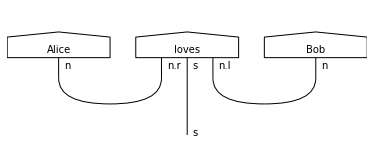

In [5]:
n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))

F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0]})

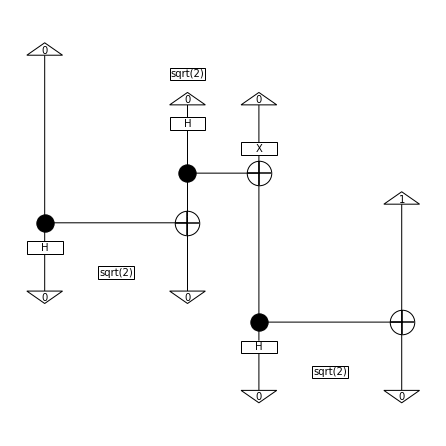

In [6]:
F_ = circuit.Functor(
    ob={s: Ty(), n: qubit},
    ar={Alice: Ket(0),
        loves: sqrt(2) @ Ket(0, 0) >> H @ X >> CX,
        Bob: Ket(1)})

F_(sentence).draw(figsize=(6, 6))

assert F_(sentence).eval() == F(sentence)

Of course this is a toy example: we've picked by hand what the circuits for Alice, loves and Bob should be so that they fit our interpretation. In order to apply our QNLP model to the real world, we need to **learn** from data what the circuits should be. In practice, we pick a parametrised circuit for each type of word, an **ansatz**, we then tune the parameters so that they reproduce our data.

**Reading:** Check out the [alice-loves-bob](https://discopy.readthedocs.io/en/main/notebooks/alice-loves-bob.html) notebook, where we use [jax](https://jax.readthedocs.io/) to simulate a toy QNLP model that learns the meaning of the verb "loves". In [bob-is-rich](https://discopy.readthedocs.io/en/main/notebooks/bob-is-rich.html), we show a slightly more complex example where the GHZ state is used to encode the meaning of relative pronouns.

**Reading:** Check out the [qnlp-experiment](https://discopy.readthedocs.io/en/main/notebooks/qnlp-experiment.html) where we run these toy models on quantum hardware.

**Exercise:** Run your own QNLP experiment on quantum hardware! There are multiple parameters that you can try to scale: the length of sentences, the size of the vocabulary, the number of qubits for the noun space.

In [ ]:
#TODO midsummer

**Exercise:** Implement a [swap test](https://en.wikipedia.org/wiki/Swap_test) to compute whether "Alice" is an answer to "Who loves Bob?".

In [ ]:
question = Who @ loves @ Bob\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 


n, s, q = Ty('n'), Ty('s'), Ty('q')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)
Who = Word("Who", q @ s.l @ n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))

F = tensor.Functor(
    ob={n: 2, s: 1, q=2},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0], Who: [1, 0, 0, 1]})

F_ = circuit.Functor(
    ob={s: Ty(), n: qubit},
    ar={Alice: Ket(0),
        loves: sqrt(2) @ Ket(0, 0) >> H @ X >> CX,
        Bob: Ket(1)})

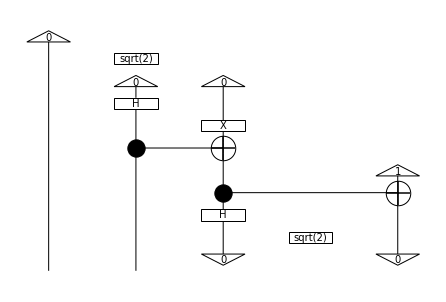

In [28]:
question = Alice @ loves @ Bob >> Id(n) @ Id(n.r) @ Id(s) @ Cup(n.l, n)
F_(question).draw()

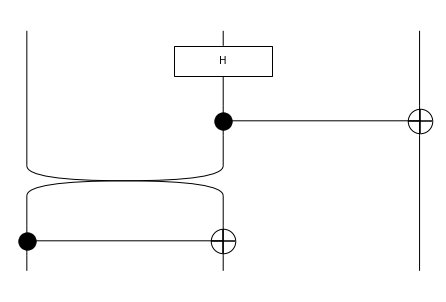

In [32]:
GHZ = Id(1) @ H @ Id(1)\
    >> Id(1) @ CX\
    >> (SWAP >>  CX) @ Id(1)
GHZ.draw()

In [33]:
import pytket as tk

In [37]:
c = tk.Circuit(3)

In [51]:
c = tk.Circuit(2)
c.SWAP(0,1)

[SWAP q[0], q[1]; ]

In [39]:
c.CSWAP(0,1,2)

[CSWAP q[0], q[1], q[2]; ]

In [46]:
from pytket.transform import Transform

In [48]:
ccx = Transform.DecomposeCCX()
# DecomposeCCX()

In [52]:
d = ccx.apply(c)

In [53]:
d

False

In [45]:
Circuit.from_tk(c)

NotImplementedError: 

In [ ]:
tk.

In [ ]:
cswap = 

In [ ]:
swap_test = 

In [ ]:
n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))

F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0]})

In [ ]:
F_ = circuit.Functor(
    ob={s: Ty(), n: qubit},
    ar={Alice: Ket(0),
        loves: sqrt(2) @ Ket(0, 0) >> H @ X >> CX,
        Bob: Ket(1)})

F_(sentence).draw(figsize=(6, 6))

assert F_(sentence).eval() == F(sentence)

## References

* Coecke, B., Sadrzadeh, M., & Clark, S. (2010) _Mathematical foundations for a compositional distributional model of meaning._ [arXiv:1003.4394](https://arxiv.org/abs/1003.4394)
* Zeng, W., & Coecke, B.  (2016) _Quantum algorithms for compositional natural language processing._ [arXiv:1608.01406](https://arxiv.org/abs/arXiv:1608.01406)
* de Felice, G., Toumi, A., & Coecke, B. (2020) _DisCoPy: Monoidal Categories in Python._ [arXiv:2005.02975](https://arxiv.org/abs/2005.02975)
* Meichanetzidis, K., Toumi, A., de Felice, G., & Coecke, B. (2020) _Grammar-Aware Question-Answering on Quantum Computers._ [arXiv:2012.03756](https://arxiv.org/abs/arXiv:2012.03756)
* Meichanetzidis, K., Gogioso, S., De Felice, G., Chiappori, N., Toumi, A., & Coecke, B. (2020) _Quantum natural language processing on near-term quantum computers._ [arXiv:2005.04147](https://arxiv.org/abs/arXiv:2005.04147)